In [2]:
%pylab inline
import os
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
path = Path("/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade")
path.ls()

[PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/labels.txt'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/Oldlabels'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/labels'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/test.txt'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/train.txt'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/images/05june05_static_street_boston__p1010862.jpg'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/images/web_static_outdoor_street_freiberg_germany__freiberg14.jpg'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/images/static_barcelona_street_city_outdoor_2005__img_0315.jpg')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/labels/spatial_envelope_256x256_static_8outdoorcategories__insidecity_art1026.png'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/labels/static_outdoor_urban_city_street_coruna_spain__IMG_8164.png'),
 PosixPath('/content/drive/My Drive/3rd Sem/Computer Vision/Project/labelmefacade/labels/static_street_statacenter_cambridge_outdoor_2005__img_0257.png')]

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{".png"}'
#classes = array(['__ignore__', 'Roof', 'Facade', 'Sky', 'Road', 'Tree'])
classes = np.loadtxt(path/'labels.txt', dtype=str);

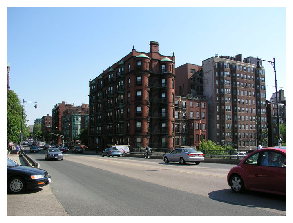

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

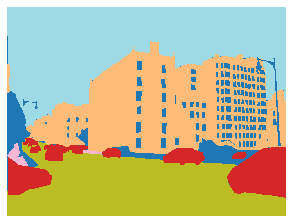

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data
np.unique(mask.data)

array([0, 1, 2, 4, 5, 6])

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=4)
        .normalize(imagenet_stats))

In [0]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [0]:
#metrics=acc_camvid
metrics=pixel_accuracy

In [0]:
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=pixel_accuracy, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 33.7MB/s]


In [0]:
#lr_find(learn)
#learn.recorder.plot()

In [20]:
lr=3e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,pixel_accuracy,time
0,1.040128,0.954476,0.690427,08:05
1,0.768645,0.825263,0.701729,01:58
2,0.650114,0.674077,0.761173,01:58
3,0.675792,0.642080,0.766059,01:58
4,0.648491,0.611417,0.780455,01:58
5,0.606376,0.634444,0.779222,01:58
6,0.590677,0.569734,0.798525,01:58
7,0.550024,0.604260,0.789441,01:58
8,0.531183,0.606853,0.781455,01:58
9,0.473403,0.519454,0.810356,01:57


In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [23]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.457175,0.517481,0.811158,02:09
1,0.450255,0.516014,0.810512,02:08
2,0.433834,0.522731,0.807994,02:08
3,0.429857,0.515576,0.810430,02:08
4,0.422357,0.510906,0.812155,02:08
5,0.418478,0.550153,0.800281,02:08
6,0.410511,0.520470,0.811321,02:09
7,0.407415,0.512690,0.812937,02:08
8,0.396713,0.500528,0.815624,02:08
9,0.382451,0.511480,0.814883,02:09


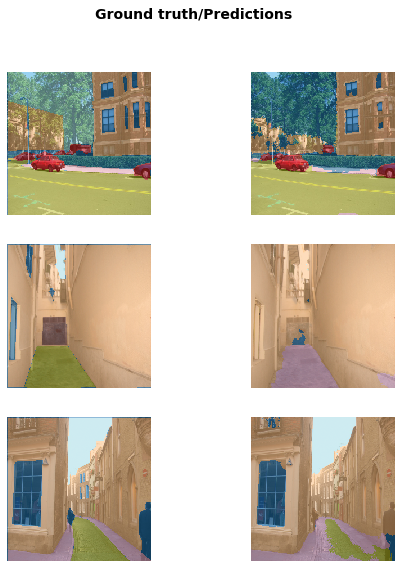

In [24]:
learn.show_results(rows=3, figsize=(8,9))